In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

In [173]:
df = pd.read_csv ("True_model.csv")

x = df['周波数 [MHz]\n']
y = df['FG model + 21cm model + error[K]\n']

In [174]:
nu_c = 75
def AIC(r2, k):
    Se = np.sum( r2**2 / 0.025**2 )
    L = np.exp( - Se / 2 )
    return - 2 * np.log( L ) + 2 * k 

def BIC(r2, k):
    n = 103
    Se = np.sum( r2**2 / 0.025**2 )
    L = np.exp( - Se / 2 )
    return - 2 * np.log( L ) + k * np.log(n) 

def f(x,a,b,c,d,e):
    return a * ( x / nu_c )**-2.5 + b * ( x / nu_c )**-2.5 * np.log( x / nu_c ) \
                        + c * ( x / nu_c )**-2.5 * (np.log(x / nu_c))**2 \
                        + d * ( x / nu_c )**-4.5 + e * ( x / nu_c )**-2
  
def GSmodel(x, p0, p1, p2, p3):
    A_21 = p0
    nu_21 = p1
    w_21 = p2
    tau_21 = p3
    B_21 = 4 * np.power(x-nu_21,2) /w_21/w_21 \
        * np.log(-np.log((1+np.exp(-1*tau_21))*0.5)/tau_21)
    T_21 = -1*A_21 * (1-np.exp(-1*tau_21 * np.exp(B_21))) / (1-np.exp(-1*tau_21))
    return T_21

def sin_model( x, V, a0, a1, P ):
    T_cal = ( x / nu_c ) ** V *  ( a0 * np.sin( 2 * np.pi * x / P) + a1 * np.cos( 2 * np.pi * x / P )) 
    return T_cal
    
def fgs(x, a, b, c, d, e, p0, p1, p2, p3, V, a0, a1, P):
    return f(x, a, b, c, d, e) + GSmodel(x, p0, p1, p2, p3) + sin_model( x, V, a0, a1, P )

In [175]:
yerr = 0.025
def lnlike(theta, x, y, yerr):
    a, b, c, d, e, p0, p1, p2, p3, V, a0, a1, P = theta
    model = fgs(x, a, b, c, d, e, p0, p1, p2, p3, V, a0, a1, P) 
    inv_sigma2 = 1.0 / (0.025**2)
    return -0.5*(np.sum( (y-model)**2 * inv_sigma2) )

In [176]:
a_t = -5.88404512e+03 
b_t = -3.73866143e+03 
c_t = -1.16478763e+03
d_t = 7.81724589e+01
e_t = 7.55530591e+03
p0_t = 4.43169630e-01  
p1_t = 7.83884244e+01  
p2_t = 1.91511501e+01
p3_t = 1.18670823e+01
V_t =  -3.27676385e-02
a0_t = -2.09572524e-03
a1_t = -6.80382210e-03
P_t = 1.21031651e+01

In [177]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [a_t, b_t, c_t, d_t, e_t, p0_t, p1_t, p2_t, p3_t, V_t, a0_t, a1_t, P_t], args=(x, y, yerr))
a_t, b_t, c_t, d_t, e_t, p0_t, p1_t, p2_t, p3_t, V_t, a0_t, a1_t, P_t = result["x"]

In [178]:
result['x']

array([-5.86064464e+03, -3.72964732e+03, -1.15961642e+03,  7.83449961e+01,
        7.53294509e+03,  4.39496258e-01,  7.82163921e+01,  1.94739528e+01,
        9.03237708e+00, -5.58175478e+00, -1.24054400e-02, -3.39992739e-03,
        1.17909943e+01])

In [179]:
F = fgs(x, a_t, b_t, c_t, d_t, e_t, p0_t, p1_t, p2_t, p3_t, V_t, a0_t, a1_t, P_t )
np.mean( ( y - F )**2 )**0.5 * 1000

26.102694373167274

In [180]:
AIC(y - F, 13),BIC(y - F, 13)

(138.28658770322355, 172.53806455020882)

rms = 0.02610269437319388, AIC = 138.28658770345257


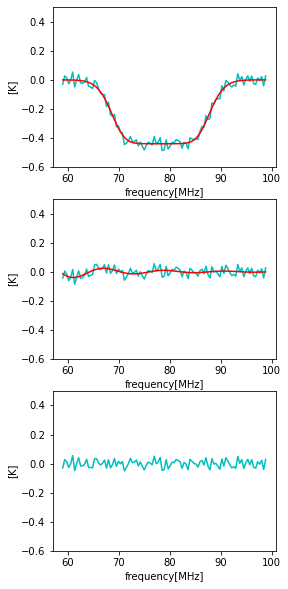

In [181]:
fig = plt.figure(figsize=(4,10))

ax = fig.add_subplot(311)
ax.set_ylim(-0.6, 0.5)
r1 = y - f(x, a_t, b_t, c_t, d_t, e_t ) - sin_model(x, V_t, a0_t, a1_t, P_t)
ax.plot(x, r1, c = 'c')
ax.plot(x, GSmodel(x, p0_t, p1_t, p2_t, p3_t) , c = 'r' )
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r2 = y - f(x, a_t, b_t, c_t, d_t, e_t ) - GSmodel(x, p0_t, p1_t, p2_t, p3_t,)
ax = fig.add_subplot(312)
ax.set_ylim(-0.6, 0.5)
ax.plot(x, r2, color="c")
ax.plot(x, sin_model(x,V_t, a0_t, a1_t, P_t),c='r')
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r3 = y - f(x, a_t, b_t, c_t, d_t, e_t ) - GSmodel(x, p0_t, p1_t, p2_t, p3_t,)- sin_model(x, V_t, a0_t, a1_t, P_t)
ax = fig.add_subplot(313)
ax.set_ylim(-0.6, 0.5)
ax.plot(x, r3, color="c")
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

print("rms = {}, AIC = {}".format( ( np.mean(r3**2) )**0.5, AIC(r3,13 ) ))

fig.savefig("model2.png")
plt.show()

In [182]:
def lnprior(theta):
    a, b, c, d, e, p0, p1, p2, p3, V, a0, a1, P = theta
    if 0.1 < p0 < 1 and 60 < p1 < 90 and 5 < p2 < 40 and 0 < p3 < 40 and -4 < V < 4 and -10 < a0 < 2 and -10 < a1 < 2 and 10 < P < 15:
        return 0.0
    return -np.inf

In [183]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [227]:
ndim, nwalkers = 13, 5000
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [228]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [229]:
sampler.run_mcmc(pos, 5555, progress=True)
samples = sampler.get_chain()
print(samples.shape)

  0%|          | 0/5555 [00:00<?, ?it/s]/Users/daiki/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5555/5555 [02:47<00:00, 33.14it/s]

(5555, 5000, 13)


In [222]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [243]:
flat_samples = sampler.get_chain(discard=200, thin=70, flat=True)
print(flat_samples.shape)

(380000, 13)


In [244]:
flat_samples[0]

array([-5.86064457e+03, -3.72964734e+03, -1.15961642e+03,  7.83449485e+01,
        7.53294503e+03,  4.39505684e-01,  7.82166546e+01,  1.94738651e+01,
        9.03238111e+00, -5.58185606e+00, -1.24287333e-02, -3.41309996e-03,
        1.17909698e+01])

In [245]:
from IPython.display import display, Math
labels=["a", "b", "c", "d","e","A", "nu_0","w","tau","p_0"," p_1", "p_2","p_3"]
true = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    true.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [246]:
a, b, c, d, e, p0, p1, p2, p3, V, a0, a1, P  = true

rms = 26.102694761321864mK, AIC = 138.28659104269155, BIC=172.53806788967682


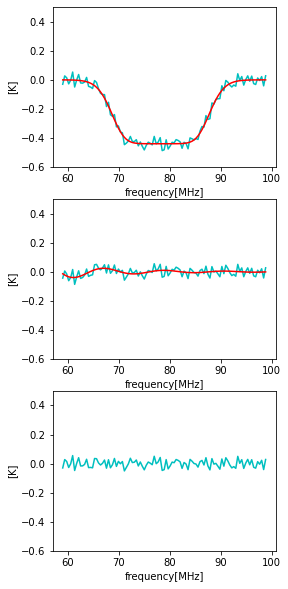

In [248]:
fig = plt.figure(figsize=(4,10))

ax = fig.add_subplot(311)
ax.set_ylim(-0.6, 0.5)
r1 = y - f(x, a, b, c, d, e ) - sin_model(x, V, a0, a1, P)
ax.plot(x, r1, c = 'c')
ax.plot(x, GSmodel(x, p0, p1, p2, p3) , c = 'r' )
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r2 = y - f(x, a, b, c, d, e ) - GSmodel(x, p0, p1, p2, p3)
ax = fig.add_subplot(312)
ax.set_ylim(-0.6, 0.5)
ax.plot(x, r2, color="c")
ax.plot(x, sin_model(x,V, a0, a1, P),c='r')
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r3 = y - f(x, a, b, c, d, e ) - GSmodel(x, p0, p1, p2, p3,)- sin_model(x, V, a0, a1, P)
ax = fig.add_subplot(313)
ax.set_ylim(-0.6, 0.5)
ax.plot(x, r3, color="c")
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

print("rms = {}mK, AIC = {}, BIC={}".format( ( np.mean(r3**2) )**0.5 * 1000, AIC(r3,13 ), BIC(r3, 13) ))

fig.savefig("model2.png")
plt.show()

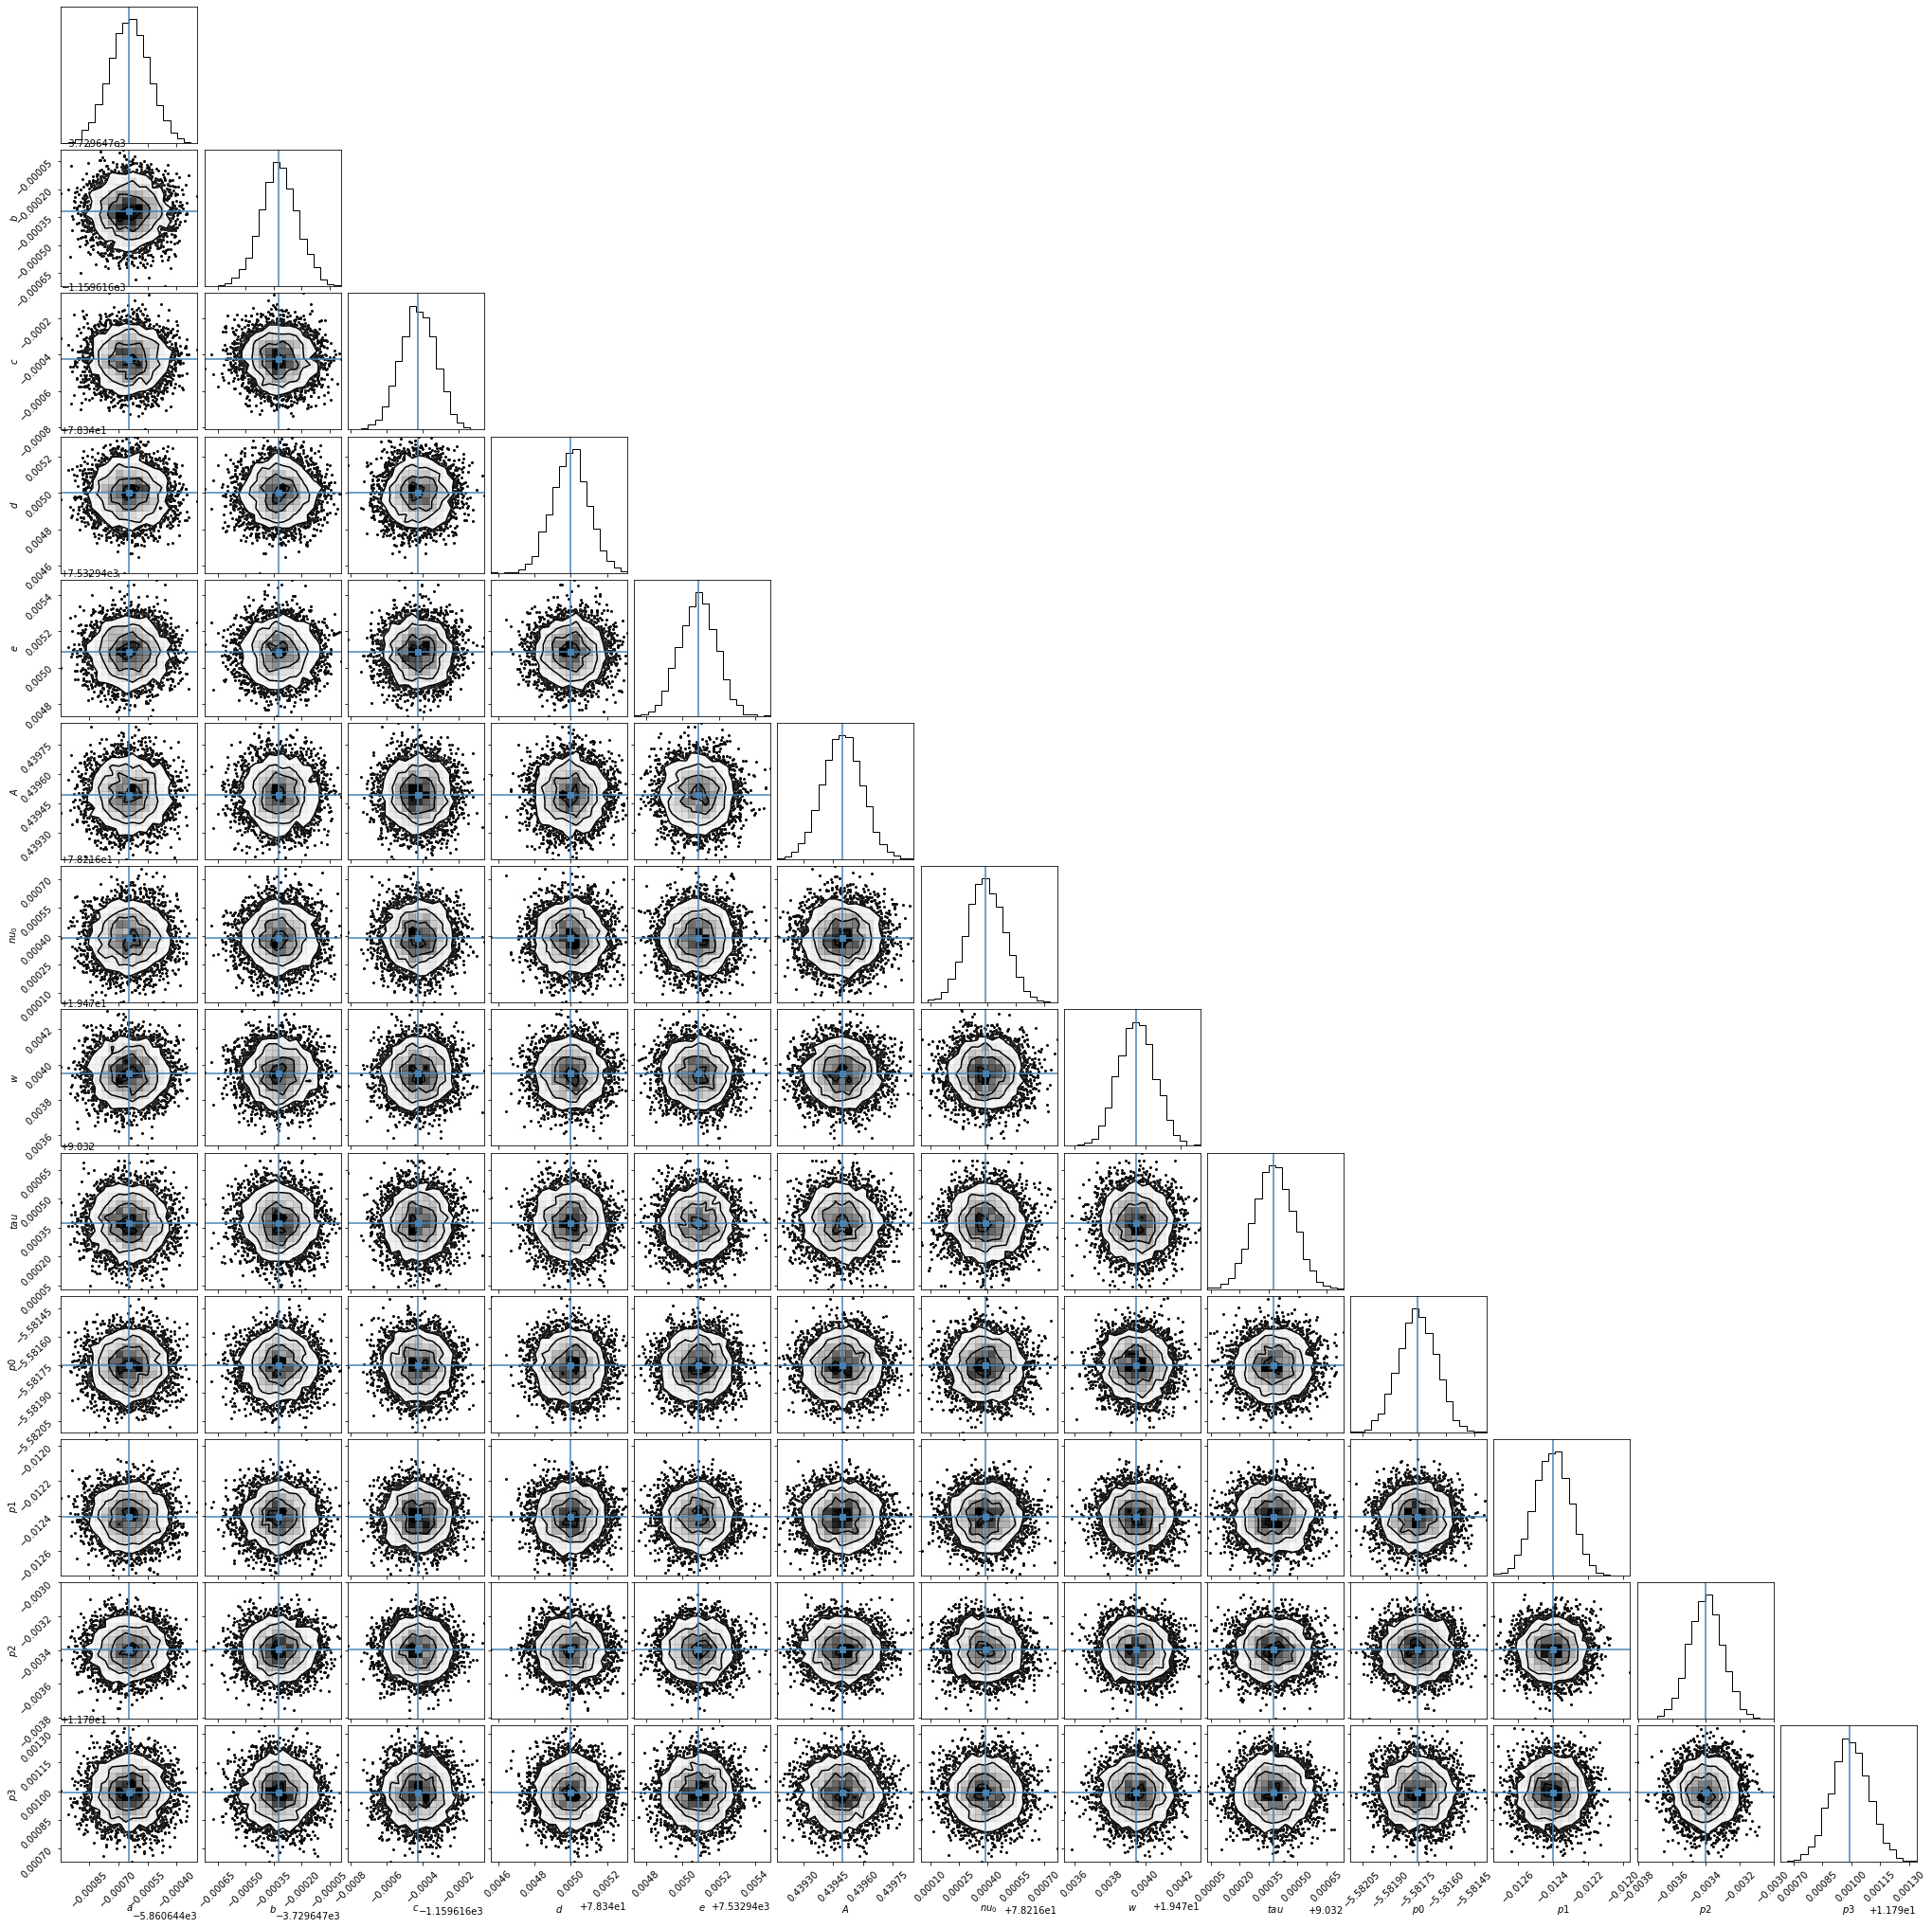

In [249]:
import corner
fig = corner.corner(flat_samples, labels=["$a$", "$b$", "$c$", "$d$","$e$", "$A$", "$nu_0$", "$w$","$tau$","$p0$"," $p1$", "$p2$","$p3$"],
                      truths=true )
fig.savefig("model2.png")

In [254]:
frequency = x
data = y
p_init = np.array(
    [-5.88404512e+03, -3.73866143e+03, -1.16478763e+03, 7.93874947e+01, 7.55530591e+03
     ,3.91699302e+00, 15.10356811e+00,  7.3336946e+01
     ,-3.38557117e-01, -2.32255488e-03,  7.16581716e-02,  1.30683008e+01]
)
bounds3=( [ -7000, -5000, -1300, 50, 5000,
        0 , 5, 60,
          -4, -10, -10, 10
         ],
        [  -4000, -3000 , -900, 100, 9000,
         10, 40, 85,
         4, 2, 2, 15
        ])

#3
Fit_y, cov = curve_fit(fgs, frequency, data, p0=p_init, maxfev=1000000, bounds=bounds3)

r1 = data - f(frequency, Fit_y[0], Fit_y[1], Fit_y[2], Fit_y[3], Fit_y[4])- sin_model(frequency, Fit_y[8], Fit_y[9], Fit_y[10],Fit_y[11])
ax = fig.add_subplot(343)
ax.set_ylim(y_min, y_max)

ax.plot(frequency, r1, c = 'c')
ax.plot(frequency,  GSmodel(frequency, Fit_y[5], Fit_y[6], Fit_y[7]), c = 'r' , alpha = 0.9)
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r2 = data - f(frequency, Fit_y[0], Fit_y[1], Fit_y[2], Fit_y[3], Fit_y[4]) - GSmodel(frequency, Fit_y[5], Fit_y[6], Fit_y[7])

ax = fig.add_subplot(347)
ax.set_ylim(y_min, y_max)

ax.plot(frequency, r2, label="fit" , color = 'c')
ax.plot(frequency, sin_model(frequency, Fit_y[8], Fit_y[9], Fit_y[10],Fit_y[11]), c = 'r', alpha = .9)
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

r3 = data - f(frequency, Fit_y[0], Fit_y[1], Fit_y[2], Fit_y[3], Fit_y[4]) - GSmodel(frequency, Fit_y[5], Fit_y[6] , Fit_y[7] )\
- sin_model(frequency, Fit_y[8], Fit_y[9], Fit_y[10],Fit_y[11])

ax = fig.add_subplot(3,4,11)
ax.set_ylim(y_min, y_max)

ax.plot(frequency, r3, label="fit" , color = 'c')
ax.set_xlabel("frequency[MHz]")

ax.legend()
ax.set_ylabel("[K]")

print("rms = {}mK, AIC = {}, BIC = {}".format( ( np.mean(r3**2) )**0.5 * 1000, AIC( r3,k =  12 ), BIC(r3,k=12)) )

TypeError: fgs() missing 1 required positional argument: 'P'